In [2]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm.auto import tqdm

from policy import config
from policy.dataset.ms2dataset import get_MS_loaders
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/032"
cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)

# Dataset
cfg["data"]["pad"] = False
cfg["data"]["augment"] = False
# cfg["data"]["full_seq"] = False
cfg["data"]["max_count"] = 0
cfg["data"]["val_split"] = 0
cfg["data"]["dataset"] = "/home/mrl/Documents/Projects/tskill/data/demos/v0/rigid_body/PegInsertionSide-v0/trajectory.rgbd.pd_joint_delta_pos.h5"

# Load only the full episode version of the dataset
train_dataset, val_dataset = get_MS_loaders(cfg, return_datasets=True, 
                                            save_override=True,
                                            preshuffle=False,
                                            )
print(len(train_dataset), len(val_dataset))
# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model.pt")
stt_encoder = model.stt_encoder
model.eval()

Found existing data info file
Loading indices from file: out/PegInsertion/032/data_info.pickle
Loading action and state scaling from file
Adding batch dimension to returned data!
6973 819
freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/032/model.pt
=> Loading checkpoint from local file...


/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but

load state dict: <All keys matched successfully>


TSkillCVAE(
  (decoder): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
       

In [34]:
def reconstruct_image(target_features, model, num_iterations=10000, learning_rate=0.01, starting_point=None):
    # Initialize input image
    if starting_point is None:
        input_image = torch.randn(1, 1, 1, 3, 128, 128, requires_grad=True)
    else:
        input_image = torch.tensor(torch.clone(starting_point.detach()), requires_grad=True)

    # Define optimizer
    optimizer = torch.optim.Adam([input_image], lr=learning_rate)

    for i in range(num_iterations):
        # Forward pass
        features = model(input_image)[0]
        
        # Compute loss
        loss = nn.MSELoss()(features, target_features)
        
        # Add regularization if needed
        # loss += regularization_term(input_image)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Optional: Clip values to valid image range
        input_image.data.clamp_(0, 1)
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return input_image.detach()


In [25]:
# Generate target features (in practice, these would come from your specific task)
i = 1
data = train_dataset[i]
img = data["rgb"][:,0:1,1:2,...]
print(img.shape)

target_features = stt_encoder(img)[0]
print(target_features.shape)

# # Reconstruct image
reconstructed_image = reconstruct_image(target_features, stt_encoder)

torch.Size([1, 1, 1, 3, 128, 128])
torch.Size([1, 1, 1, 16, 512])
Iteration 0, Loss: 2.3182756900787354
Iteration 100, Loss: 0.23639105260372162
Iteration 200, Loss: 0.1266825795173645
Iteration 300, Loss: 0.09185238182544708
Iteration 400, Loss: 0.07371031492948532
Iteration 500, Loss: 0.06265485286712646
Iteration 600, Loss: 0.054424040019512177
Iteration 700, Loss: 0.05048828944563866
Iteration 800, Loss: 0.04855094105005264
Iteration 900, Loss: 0.04469931498169899
Iteration 1000, Loss: 0.04372916743159294
Iteration 1100, Loss: 0.039689648896455765
Iteration 1200, Loss: 0.038972407579422
Iteration 1300, Loss: 0.03763367980718613
Iteration 1400, Loss: 0.036379966884851456
Iteration 1500, Loss: 0.034733183681964874
Iteration 1600, Loss: 0.03193911164999008
Iteration 1700, Loss: 0.032498057931661606
Iteration 1800, Loss: 0.029908444732427597
Iteration 1900, Loss: 0.028917860239744186
Iteration 2000, Loss: 0.02787633053958416
Iteration 2100, Loss: 0.02604515664279461
Iteration 2200, Los

torch.Size([1, 1, 1, 3, 128, 128])


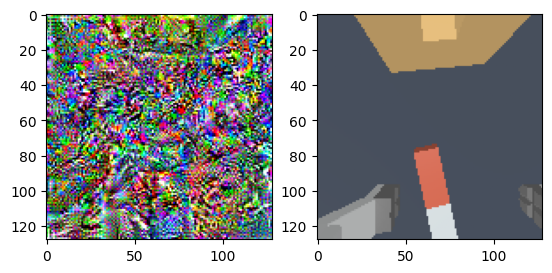

In [37]:
import matplotlib.pyplot as plt
print(reconstructed_image.shape)
fig = plt.figure()
ax1, ax2 = fig.subplots(1,2)
ax1.imshow(reconstructed_image.squeeze().permute(1,2,0))
ax2.imshow(img.squeeze().permute(1,2,0))

In [36]:
reconstructed_image = reconstruct_image(target_features, stt_encoder, starting_point=reconstructed_image, learning_rate=0.001)

/tmp/ipykernel_2906509/3916408817.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(torch.clone(starting_point.detach()), requires_grad=True)


Iteration 0, Loss: 0.008512528613209724
Iteration 100, Loss: 0.007362688891589642
Iteration 200, Loss: 0.007196552120149136
Iteration 300, Loss: 0.007059897296130657
Iteration 400, Loss: 0.006953086704015732
Iteration 500, Loss: 0.006845980882644653
Iteration 600, Loss: 0.0067733475007116795
Iteration 700, Loss: 0.006685714237391949
Iteration 800, Loss: 0.006615528371185064
Iteration 900, Loss: 0.006542450748383999
Iteration 1000, Loss: 0.006489626597613096
Iteration 1100, Loss: 0.0064337668009102345
Iteration 1200, Loss: 0.006380017381161451
Iteration 1300, Loss: 0.006338347680866718
Iteration 1400, Loss: 0.0062577552162110806
Iteration 1500, Loss: 0.006197179667651653
Iteration 1600, Loss: 0.0061424728482961655
Iteration 1700, Loss: 0.0061380285769701
Iteration 1800, Loss: 0.006064948625862598
Iteration 1900, Loss: 0.006023587193340063
Iteration 2000, Loss: 0.006009593605995178
Iteration 2100, Loss: 0.005963414441794157
Iteration 2200, Loss: 0.00592726981267333
Iteration 2300, Loss: 